In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 


train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

#train shape
print(train.shape)
#test shape
print(test.shape)

(114321, 133)
(114393, 132)


In [3]:
train.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


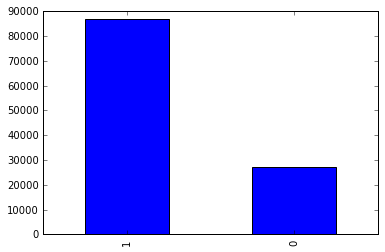

In [4]:
#target varibale 
train.target.value_counts().plot.bar()

In [5]:
#https://www.kaggle.com/chabir/bnp-paribas-cardif-claims-management/extratreesclassifier-score-0-45-v5

print('Load data...')
train = pd.read_csv("../input/train.csv")
target = train['target'].values
train = train[['v3','v10','v12','v14','v21','v22','v24','v30','v31','v34','v38','v40','v47','v50','v52','v56','v62','v66','v71','v72','v74','v75','v79','v91','v107','v110','v112','v113','v114','v125','v129']]
test = pd.read_csv("../input/test.csv")
id_test = test['ID'].values
test = test[['v3','v10','v12','v14','v21','v22','v24','v30','v31','v34','v38','v40','v47','v50','v52','v56','v62','v66','v71','v72','v74','v75','v79','v91','v107','v110','v112','v113','v114','v125','v129']]




print('Clearing...')
for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(),test.iteritems()):
    if train_series.dtype == 'O':
        #for objects: factorize
        train[train_name], tmp_indexer = pd.factorize(train[train_name])
        test[test_name] = tmp_indexer.get_indexer(test[test_name])
        #but now we have -1 values (NaN)
    else:
        #for int or float: fill NaN
        tmp_len = len(train[train_series.isnull()])
        if tmp_len>0:
            #print "mean", train_series.mean()
            train.loc[train_series.isnull(), train_name] = -999 
        #and Test
        tmp_len = len(test[test_series.isnull()])
        if tmp_len>0:
            test.loc[test_series.isnull(), test_name] = -999

X_train = train
X_test = test


Load data...
Clearing...


In [ ]:
print('Training...')
extc = ExtraTreesClassifier(n_estimators=1200,max_features= 30,criterion= 'entropy',min_samples_split= 2,
                            max_depth= 30, min_samples_leaf= 2, n_jobs = -1)    

extc.fit(X_train,target) 

print('Predict...')
y_pred = extc.predict_proba(X_test)

pd.DataFrame({"ID": id_test, "PredictedProb": y_pred[:,1]}).to_csv('extra_trees.csv',index=False)

### LibFM (https://github.com/srendle/libfm)

In [6]:
print X_train.shape
print target.shape
print X_test.shape

(114321, 31)
(114321,)
(114393, 31)


In [7]:
#from Vitaliy Radchenko
from sklearn.base import TransformerMixin
class DataFrameFiller(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
           if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
           index=X.columns)
        return self
   
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [25]:
train = pd.read_csv("../input/train.csv")
target = train['target'].values
test = pd.read_csv("../input/test.csv")
id_test = test['ID'].values


train = DataFrameFiller().fit_transform(train)
test = DataFrameFiller().fit_transform(test)

print('Clearing...')
for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(),test.iteritems()):
    if train_series.dtype == 'O':
        #for objects: factorize
        train[train_name], tmp_indexer = pd.factorize(train[train_name])
        test[train_name] = tmp_indexer.get_indexer(test[train_name])
        #but now we have -1 values (NaN)
    else:
        #for int or float: fill NaN
        tmp_len = len(train[train_series.isnull()])
        if tmp_len>0:
            #print "mean", train_series.mean()
            train.loc[train_series.isnull(), train_name] = -999 
        #and Test
        tmp_len = len(test[test_series.isnull()])
        if tmp_len>0:
            test.loc[test_series.isnull(), test_name] = -999

            
for f in train.columns:
    # fill NaN values withm -1
    if train[f].dtype == 'float64':
        train.loc[:,f][np.isnan(train[f])] = -1
        test[f][np.isnan(test[f])] = -1
        
    # fill NaN values with -1
    elif train[f].dtype == 'object':
        train[f][train[f] != train[f]] = -1
        test[f][test[f] != test[f]] = -1




/Users/kupa/.virtualenv/ds/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kupa/.virtualenv/ds/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Clearing...


In [28]:
from sklearn.datasets import dump_svmlight_file

libfm_target = map(lambda x: -1 if x < 0.5 else 1, target)
dump_svmlight_file(train,libfm_target,'../input/libfm_train.dat',zero_based=True,multilabel=False)

#Labels should be provided for the test set: https://groups.google.com/forum/#!topic/libfm/EOl8ZPBQaJY
dump_svmlight_file(test,np.zeros((X_test.shape[0],)),'../input/libfm_test.dat',zero_based=True,multilabel=False)

In [32]:
libfm_predictions = pd.read_csv('../output/libfm_predictions.dat', header=None)
pd.DataFrame({"ID": id_test, "PredictedProb": libfm_predictions.iloc[:,0]}).to_csv('../output/libfm_long_2_submit.csv',index=False)

# Kaggle training

## Feature engineering

* Genetic programming
* Target class percentage
* Interactions
* Text features interpretations

## Algorithms

* LogReg + Ridge / Lasso / Elastic
* LibFM http://libfm.org
* RGF http://stat.rutgers.edu/home/tzhang/software/rgf/
* Neural Network Keras / Lasagne / Caffe / Tensorflow
* SVM /SVMV 
* ET / RF / XGBoost hyperopt 

## 2nd level 

* Stacking 
* Blending 
* Voting 